# Packages and Datasets

In [34]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'fancyimpute', 'pdpbox', 'imblearn', 'dtreeviz.trees', 'graphviz'}
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install fancyimpute
    !pip install pdpbox
    !pip install dtreeviz
    !pip install graphviz
    !pip install imblearn
    
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [35]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

# Data Merge & Split

In [36]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
non_passengers = people[people.PERSON_ID.str.contains('^O')]

# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(non_passengers, 
                                      how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])

merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (68503, 144)


In [37]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (54802, 144)
Test shape (13701, 144)


In [38]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

In [39]:
# Drop the features that are not needed
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "DATE_POLICE_NOTIFIED","BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "WORK_ZONE_TYPE", "WORKERS_PRESENT_I","INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", "CRASH_RECORD_ID",
                      "CRASH_DATE", "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID",
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION","DAMAGE","CRASH_TYPE","MODEL",
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]

**Columns needs to be fixed**

TRAFFIC_CONTROL_DEVICE- UNKNOWN, OTHER
DEVICE_CONDITION - UNKNOWN, OTHER
WEATHER_CONDITION - UNKNOWN, OTHER
LIGHTING_CONDITION - UNKNOWN
TRAFFICWAY_TYPE - UNKNOWN, OTHER
ROADWAY_SURFACE_COND - UNKNOWN, OTHER
ROAD_DEFECT - UNKNOWN, OTHER
PRIM_CONTRIBUTORY_CAUSE- UNABLE TO DETERMINE
SEC_CONTRIBUTORY_CAUSE - UNABLE TO DETERMINE
MODEL - UNKNOWN
VEHICLE_DEFECT - UNKNOWN, OTHER
VEHICLE_TYPE - UNKNOWN/NA
TRAVEL_DIRECTION - UNKNOWN
MANEUVER - UNKNOWN/NA
SEX - X
SAFETY_EQUIPMENT - USAGE UNKNOWN
AIRBAG_DEPLOYED - DEPLOYMENT UNKNOWN
EJECTION - UNKNOWN
DRIVER_ACTION - UNKNOWN
DRIVER_VISION - UNKNOWN
PHYSICAL_CONDITION - UNKNOWN
PEDPEDAL_ACTION - UNKNOWN/NA 

In [40]:
train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan

## Missing value overview on train data

In [41]:
# replacing TRAFFIC_CONTROL_DEVICE with No Controls 
# replacing DEVICE_CONDITION with No Controls 

train.fillna({
    'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
    'DEVICE_CONDITION': 'NO CONTROLS',
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'ROADWAY_SURFACE_COND': 'NO DEFECTS',
    'ROAD_DEFECT': 'CLEAR',
    'INTERSECTION_RELATED_I': 'N',
    
    'NOT_RIGHT_OF_WAY_I': 'N',
    'HIT_AND_RUN_I': 'N',
    'DOORING_I': 'N',
    'WORK_ZONE_I': 'N',
    'NUM_PASSENGERS': 0,
    'LIC_PLATE_STATE': 'IL',
    'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
    'VEHICLE_TYPE': 'OTHER',
    
    'VEHICLE_USE': 'OTHER',
    'TRAVEL_DIRECTION': 'UNABLE TO DETERMINE', # UPDATED
    'MANEUVER': 'OTHER',
    'OCCUPANT_CNT': 0,
    'EXCEED_SPEED_LIMIT_I': 'N',
    'FIRST_CONTACT_POINT': 'OTHER',
    'PERSON_TYPE': 'UNABLE TO DETERMINE',
    'CITY': 'OTHER',
    
    'SEX': 'UNABLE TO DETERMINE', #or X ?
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
    'EJECTION': 'UNABLE TO DETERMINE',
    'DRIVER_ACTION': 'OTHER',
    'DRIVER_VISION': 'OTHER',
    'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',
    
    'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
    'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
    'BAC_RESULT VALUE': 0
}, inplace=True)

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [42]:
train['LANE_CNT'].fillna("2",inplace=True)

print("Total NAs in LANE_CNT is", train['LANE_CNT'].isnull().sum())

Total NAs in LANE_CNT is 0


#### Replace with median

In [43]:
train["AGE"] = pd.to_numeric(train["AGE"])
train['AGE'].fillna((train['AGE'].median()), inplace=True)

print("TOTAL NAs in AGE is", train['AGE'].isnull().sum())

TOTAL NAs in AGE is 0


#### Replace with mode/median

In [44]:
train['VEHICLE_YEAR'].fillna(train['VEHICLE_YEAR'].mode()[0], inplace=True)

train["OCCUPANT_CNT"] = pd.to_numeric(train["OCCUPANT_CNT"])
train['OCCUPANT_CNT'].fillna((train['OCCUPANT_CNT'].median()), inplace=True)

print("TOTAL NAs in VEHICLE_YEAR is", train['VEHICLE_YEAR'].isnull().sum())

TOTAL NAs in VEHICLE_YEAR is 0


#### Drop the missing rows


In [45]:
drop_rows = ['INJURIES_TOTAL', 'LATITUDE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
#train.isnull().sum()

In [46]:
train.shape

(54388, 50)

# Handling Outliers

In [47]:
numericals = ['LANE_CNT', 'NUM_UNITS', 'VEHICLE_YEAR', 'CRASH_HOUR']

for col in numericals:
    #print(train[col].value_counts())
    train[col] = pd.to_numeric(train[col])
    #print()

In [48]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6), 'LANE_CNT'] = 6
train['LANE_CNT'].value_counts()

2    44921
4     4408
1     2970
3      769
6      575
0      543
5      202
Name: LANE_CNT, dtype: int64

# Feature Engineering

##  Target Feature Engineering

In [49]:
def injury(x): 
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [50]:
train["INJURY"].value_counts()

NOT INJURED    48496
INJURED         5892
Name: INJURY, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [51]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

In [52]:
train["MANEUVER"].unique()

array(['STRAIGHT AHEAD', 'CHANGING LANES', 'TURNING LEFT',
       'TURNING RIGHT', 'PARKED', 'MERGING', 'SLOW/STOP IN TRAFFIC',
       'OTHER', 'ENTERING TRAFFIC LANE FROM PARKING',
       'PASSING/OVERTAKING', 'LEAVING TRAFFIC LANE TO PARK', 'BACKING',
       'STARTING IN TRAFFIC', 'SKIDDING/CONTROL LOSS',
       'SLOW/STOP - LEFT TURN', 'SLOW/STOP - RIGHT TURN',
       'PARKED IN TRAFFIC LANE', 'AVOIDING VEHICLES/OBJECTS',
       'SLOW/STOP - LOAD/UNLOAD', 'ENTER FROM DRIVE/ALLEY',
       'TURNING ON RED', 'DRIVING WRONG WAY', 'U-TURN',
       'NEGOTIATING A CURVE', 'DISABLED', 'DRIVERLESS', 'DIVERGING'],
      dtype=object)

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER

Reduced # layers in `VEHICLE_YEAR` to:
- NEW
- OLD (<2010)
- UNKNOWN

Reduced # layers in `POSTED_SPEED_LIMIT` to:
- LOW_SPEED (< 30mph)
- HIGH_SPEED

In [53]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [54]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"] = train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"] = train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [55]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

### TRAFFIC_CONTROL_DEVICE

Transform the signs

- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as **`SIGN`**
    
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as **`NO_SIGN`**

In [56]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

### TRAFFICWAY_TYPE

In [57]:
def traffic_way(x):
    if ("NOT" in x) or ("ONE-WAY" in x):
        return "NOT_DIVIDED"
    else:
        return "DIVIDED"

train["TRAFFICWAY_TYPE"]= train["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))

### LOCATION

In [58]:
def location(x1,x2):
    if (41.875297 <= float(x1) <= 41.9000064) and (-87.6321459 <= float(x2) <= -87.6096752):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
train["Location"] = train.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [59]:
train["Location"].unique()

array(['Downtown', 'Not Downtown'], dtype=object)

### CAR AGE

In [60]:
#train["VEHICLE_AGE"]=train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]
#train.loc[train["VEHICLE_AGE"] < 0, "VEHICLE_AGE"] = 0
#train.drop("VEHICLE_YEAR", axis=1, inplace=True)

## Summary

In [61]:
# NO MISSING VALUES LEFT!
train.isnull().sum()

POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
LANE_CNT                   0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
INTERSECTION_RELATED_I     0
NOT_RIGHT_OF_WAY_I         0
HIT_AND_RUN_I              0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
STREET_DIRECTION           0
DOORING_I                  0
WORK_ZONE_I                0
NUM_UNITS                  0
INJURIES_TOTAL             0
CRASH_HOUR                 0
LATITUDE                   0
LONGITUDE                  0
NUM_PASSENGERS             0
LIC_PLATE_STATE            0
VEHICLE_YEAR               0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER                   0
OCCUPANT_CNT               0
EXCEED_SPEED_LIMIT_I       0
FIRST_CONTACT_

In [62]:
train.shape

(54388, 51)

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54388 entries, 29244 to 15795
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   POSTED_SPEED_LIMIT       54388 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   54388 non-null  object 
 2   DEVICE_CONDITION         54388 non-null  object 
 3   WEATHER_CONDITION        54388 non-null  object 
 4   LIGHTING_CONDITION       54388 non-null  object 
 5   FIRST_CRASH_TYPE         54388 non-null  object 
 6   TRAFFICWAY_TYPE          54388 non-null  object 
 7   LANE_CNT                 54388 non-null  int64  
 8   ALIGNMENT                54388 non-null  object 
 9   ROADWAY_SURFACE_COND     54388 non-null  object 
 10  ROAD_DEFECT              54388 non-null  object 
 11  INTERSECTION_RELATED_I   54388 non-null  object 
 12  NOT_RIGHT_OF_WAY_I       54388 non-null  object 
 13  HIT_AND_RUN_I            54388 non-null  object 
 14  PRIM_CONTRIBUTORY_

# Baseline Model

These features require feature engineering.
- `LIC_PLATE_STATE`
- `PEDPEDAL_ACTION`
- `BAC_RESULT VALUE`
- `CITY`

Tony 33, Shantanu 46 features.

**Shantanu's extras**
ALIGNMENT, STREET_DIRECTION, DOORING_I, WORK_ZONE_I, NUM_PASSENGERS, LIC_PLATE_STATE, CITY, 
PEDPEDAL_ACTION, PEDPEDAL_VISIBILITY, BAC_RESULT VALUE, CELL_PHONE_USE

In [77]:
drop_list=["SEC_CONTRIBUTORY_CAUSE", "LATITUDE", "LONGITUDE", "INJURIES_TOTAL", "STREET_DIRECTION", "ALIGNMENT", 
          "NUM_PASSENGERS", "LIC_PLATE_STATE", "PEDPEDAL_ACTION", "BAC_RESULT VALUE", "CITY"]

train_new = train.drop(drop_list, axis=1)

In [78]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [79]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [80]:
print(X_train.shape)

X_train.head()

(54388, 241)


,LANE_CNT,NUM_UNITS,OCCUPANT_CNT,AGE,POSTED_SPEED_LIMIT_LOW_SPEED,TRAFFIC_CONTROL_DEVICE_SIGN,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_OTHER,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,TRAFFICWAY_TYPE_NOT_DIVIDED,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_NO DEFECTS,ROADWAY_SURFACE_COND_OTHER,"ROADWAY_SURFACE_COND_SAND, MUD, DIRT",ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_WET,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_WORN SURFACE,INTERSECTION_RELATED_I_Y,NOT_RIGHT_OF_WAY_I_Y,HIT_AND_RUN_I_Y,PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE,"PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY,PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION,"PRIM_CONTRIBUTORY_CAUSE_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT,PRIM_CONTRIBUTORY_CAUSE_EXCEEDING SAFE SPEED FOR CONDITIONS,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_NOT APPLICABLE,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,PRIM_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP,PRIM_CONTRIBUTORY_CAUSE_ROAD CONSTRUCTION/MAINTENANCE,PRIM_CONTRIBUTORY_CAUSE_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,PRIM_CONTRIBUTORY_CAUSE_TEXTING,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,DOORING_I_Y,WORK_ZONE_I_Y,CRASH_HOUR_Early_morning,CRASH_HOUR_Morning,CRASH_HOUR_Night,VEHICLE_YEAR_OLD (<2010),VEHICLE_DEFECT_CARGO,VEHICLE_DEFECT_ENGINE/MOTOR,VEHIC

**NOT INJURED will be 0 !**

In [81]:
# Encode the y_train labels
#lb = preprocessing.LabelBinarizer()
#y_train=lb.fit_transform(train_new["INJURY"])

# NOT INJURED will be 0
y_train = preprocessing.label_binarize(train_new['INJURY'], classes=['NOT INJURED', 'INJURED']) 
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

**Real Baseline Scores**

- **Accuracy: ~0.91**

- **Recall: ~0.31**

- **Precision: ~0.76**

- **F1: ~0.44**

In [82]:
#Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

#Train the model using the training sets y_pred=rf.predict(X_test)
scores = cross_val_score(rf, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

recall = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
print('Recall', np.mean(recall), recall)

precision = cross_val_score(rf, X_train, y_train, cv=5, scoring='precision', n_jobs=-1)
print('Precision', np.mean(precision), precision)

f1 = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print('F1', np.mean(f1), f1)

Accuracy 0.9143009762862926 [0.91680456 0.91165655 0.91294356 0.91275168 0.91734853]
Recall 0.3038035456366435 [0.32258065 0.29177269 0.30534351 0.28013582 0.31918506]
Precision 0.7620989086222039 [0.78028747 0.73191489 0.73770492 0.76566125 0.794926  ]
F1 0.4342533650919488 [0.45645646 0.41722256 0.43191362 0.41019267 0.45548153]


In [71]:
#Create a Random Forest Classifier
#rf = RandomForestClassifier(n_estimators=100, random_state=0)
#rf.fit(X_train,y_train)
#print(rf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
#feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
#feat_importances.nlargest(10).plot(kind='barh')
#plt.show()

In [72]:
#feat_importances.nlargest(50)

# Random undersampling

In [73]:
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","FIRST_CRASH_TYPE","LIGHTING_CONDITION","SEX"]
#"VEHICLE_AGE"
X_train = train[filter_list]
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns)

dummies_to_drop = X_train.columns[X_train.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
X_train = X_train.loc[:, ~X_train.columns.isin(dummies_to_drop)]

In [74]:
# Undersampling the data first after scaling of data
under = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train, y_train)

#X_under, y_under = under.fit_resample(X_train_scaled, y_train_new)
count = Counter(y_under)
print(count)

Counter({0: 5892, 1: 5892})


In [75]:
random_final = RandomForestClassifier(n_estimators=800, min_samples_split=15, min_samples_leaf=8,
                                     max_features='log2', max_depth=13, criterion='gini')

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [76]:
recall = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='recall', n_jobs=-1)
print('Recall', np.mean(recall), recall)

precision = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='precision', n_jobs=-1)
print('Precision', np.mean(precision), precision)

f1_score = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='f1', n_jobs=-1)
print('F1 Score', np.mean(f1_score), f1_score)

Recall 0.6872049202872568 [0.72241087 0.67657046 0.6836302  0.67938931 0.67402377]
Precision 0.8012013573070339 [0.79422719 0.80928355 0.81771894 0.7917078  0.79306931]
F1 Score 0.7400118785393464 [0.75843694 0.73909006 0.74330563 0.72727273 0.73195402]


# Iterations

## Function definitions

In [37]:
def prepare_dataset(features):
    ''' Returns a RF-ready set without one-hot encoded features of 'UNABLE','UNKNOWN','NOT APPLICABLE','OTHER'. '''
    
    X_train = train[features]
    X_train = pd.get_dummies(X_train, columns = X_train.select_dtypes(['object']).columns, drop_first = True)
    
    dummies_to_drop = X_train.columns[X_train.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
    X_train = X_train.loc[:, ~X_train.columns.isin(dummies_to_drop)]  
    return(X_train)

In [38]:
def rf_evaluator(X = X_train, y = y_train, cv = 5, n_estimators = 100, random_state = 0,
                 max_depth = None, class_weight = None, min_samples_leaf = 1, min_samples_split = 2):

    '''Runs a RF classifier with default values and returns a dataframe consists accuracy, recall, precision and f1 
    mean scores calculated by cross-validation.'''

    rf = RandomForestClassifier(n_estimators = n_estimators, 
                                random_state = random_state, 
                                max_depth = max_depth,
                                min_samples_leaf = min_samples_leaf, 
                                min_samples_split = min_samples_split,
                                class_weight = class_weight)
    rf.fit(X, y)
    
    metrics_table = []
    for metric in ['accuracy', 'recall', 'precision', 'f1']:
        metrics_table.append([metric, cross_val_score(rf, X, y, cv = cv, scoring = metric).mean()])
    
    metrics_table = pd.DataFrame(metrics_table, columns = ['metric', 'mean_score'])
    return(metrics_table)

In [39]:
def best_recall_tree_selector(n_estimators = 100, random_state = 0, class_weight = None, 
                              max_depth = None, min_samples_leaf = 1, min_samples_split = 2):
    
    '''Runs a RF classifier with default values and returns best performing tree object in terms of recall.'''
    
    rf = RandomForestClassifier(n_estimators = n_estimators,
                                random_state = random_state,
                                class_weight = class_weight,
                                max_depth = max_depth, 
                                min_samples_leaf = min_samples_leaf,
                                min_samples_split = min_samples_split)
    rf.fit(X_train, y_train)
   
    from sklearn.metrics import recall_score
    
    estimator_recall = []
    for current_tree in range(n_estimators):
        estimator_recall.append([current_tree, 
                                 recall_score(y_train, rf.estimators_[current_tree].predict(X_train))])

    estimator_recall = pd.DataFrame(estimator_recall, columns = ['tree_number', 'recall'])
    estimator_recall.sort_values(inplace = True, by = 'recall', ascending = False)

    best_recall_tree = rf.estimators_[estimator_recall.head(1)['tree_number'].values[0]]
    return(best_recall_tree)

## Yet Another Model

In [ ]:
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",
             "SEC_CONTRIBUTORY_CAUSE","VEHICLE_AGE","FIRST_CRASH_TYPE","INJURY","LIGHTING_CONDITION","SEX"]

X_train = prepare_dataset(filter_list)

print(X_train.shape)
X_train.head()

## IGNORE - 1st Small Model

In [40]:
selected_list = ['AGE', 'FIRST_CRASH_TYPE', 'LANE_CNT', 'AIRBAG_DEPLOYED', 'SEX', 
                 'TRAFFICWAY_TYPE', 'VEHICLE_YEAR', 'CRASH_HOUR', 'PRIM_CONTRIBUTORY_CAUSE', 'SAFETY_EQUIPMENT'] 
                 #'SEC_CONTRIBUTORY_CAUSE', 'NUMBER_CAUSES']

X_train = prepare_dataset(selected_list)

print(X_train.shape)
X_train.head()

(54388, 76)


,AGE,LANE_CNT,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,AIRBAG_DEPLOYED_NOT DEPLOYED,SEX_M,SEX_X,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED),TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN BARRIER,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_NOT REPORTED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_Y-INTERSECTION,VEHICLE_YEAR_OLD (<2010),CRASH_HOUR_Early_morning,CRASH_HOUR_Morning,CRASH_HOUR_Night,PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY,PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION,"PRIM_CONTRIBUTORY_CAUSE_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT,PRIM_CONTRIBUTORY_CAUSE_EXCEEDING SAFE SPEED FOR CONDITIONS,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,PRIM_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP,PRIM_CONTRIBUTORY_CAUSE_ROAD CONSTRUCTION/MAINTENANCE,PRIM_CONTRIBUTORY_CAUSE_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,PRIM_CONTRIBUTORY_CAUSE_TEXTING,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,SAFETY_EQUIPMENT_DID NOT USE SAFETY EQUIP,SAFETY_EQUIPMENT_USED SAFETY EQUIP,SAFETY_EQUIPMENT_WHEELCHAIR
29244,26.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
22376,51.0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49790,73.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
32552,38.0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1957,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
rf_evaluator()

,metric,mean_score
0,accuracy,0.914558
1,recall,0.305839
2,precision,0.764255
3,f1,0.436585


In [42]:
rf_evaluator(class_weight='balanced')

,metric,mean_score
0,accuracy,0.912242
1,recall,0.272912
2,precision,0.767571
3,f1,0.402443


## IGNORE - 2nd Small Model

In [43]:
selected_list2 = ["AGE","AIRBAG_DEPLOYED","INTERSECTION_RELATED_I","LANE_CNT","SEX","POSTED_SPEED_LIMIT","CRASH_HOUR"]

X_train = prepare_dataset(selected_list2)

print(X_train.shape)
X_train.head()

(54388, 10)


,AGE,LANE_CNT,AIRBAG_DEPLOYED_NOT DEPLOYED,INTERSECTION_RELATED_I_Y,SEX_M,SEX_X,POSTED_SPEED_LIMIT_LOW_SPEED,CRASH_HOUR_Early_morning,CRASH_HOUR_Morning,CRASH_HOUR_Night
29244,26.0,4,0,1,1,0,1,0,0,0
22376,51.0,3,1,0,1,0,1,0,0,0
49790,73.0,2,1,0,1,0,1,0,0,0
32552,38.0,2,0,0,0,0,1,0,1,0
1957,30.0,2,1,0,0,0,1,1,0,0


In [44]:
# Evaluation
rf_evaluator()

,metric,mean_score
0,accuracy,0.914558
1,recall,0.305839
2,precision,0.764255
3,f1,0.436585


## Features of Ender - Baseline

In [45]:
features_ender = ["FIRST_CRASH_TYPE","INTERSECTION_RELATED_I","LANE_CNT","TRAFFICWAY_TYPE","DEVICE_CONDITION"]

### IF YOU WANT TO SEE CATEGORIES
#for col in features_ender:
#   print('\033[1m', '\nColumn Name:', col, '\033[0m')
#   print(train[col].value_counts())

In [46]:
features_ender = ["FIRST_CRASH_TYPE","LANE_CNT","TRAFFICWAY_TYPE","DEVICE_CONDITION"]
X_train = prepare_dataset(features_ender)

print(X_train.shape)
X_train.head()

(54388, 37)


,LANE_CNT,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED),TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN BARRIER,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_NOT REPORTED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_Y-INTERSECTION,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL
29244,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22376,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
49790,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
32552,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1957,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [47]:
# Baseline
rf_evaluator()

,metric,mean_score
0,accuracy,0.914558
1,recall,0.305839
2,precision,0.764255
3,f1,0.436585


## Hyper-parameter Optimization

Optimizing hyper-parameters to achieve as **shallow and interpretable** trees as possible without compromising the recall.

**max_depth (Decision: 9)**

- int, default=None

- The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


In [48]:
max_depth_range = list(range(6, 21))

recall_depth_table = []
for depth in max_depth_range:    
    rf = RandomForestClassifier(max_depth = depth, random_state = 0, class_weight = 'balanced')
    rf.fit(X_train, y_train)
    
    from sklearn.metrics import recall_score
    recall_depth_table.append([depth, recall_score(y_train, rf.predict(X_train))])
    
recall_depth_table = pd.DataFrame(recall_depth_table, columns = ['max_depth', 'recall'])
recall_depth_table

,max_depth,recall
0,6,0.592329
1,7,0.608452
2,8,0.609301
3,9,0.631365
4,10,0.629158
5,11,0.649695
6,12,0.655804
7,13,0.655804
8,14,0.655974
9,15,0.651901


**min_samples_split (Decision: 5)** 

- int or float, default=2
- The minimum number of samples required to split an internal node

In [49]:
min_samples_split = list(range(2, 11))

recall_min_split_table = []
for min_split in min_samples_split:    
    rf = RandomForestClassifier(min_samples_split = min_split, 
                                max_depth = 9, random_state = 0, class_weight = 'balanced')
    rf.fit(X_train, y_train)
    
    from sklearn.metrics import recall_score
    recall_min_split_table.append([min_split, recall_score(y_train, rf.predict(X_train))])
    
recall_min_split_table = pd.DataFrame(recall_min_split_table, columns = ['min_samples_split', 'recall'])
recall_min_split_table

,min_samples_split,recall
0,2,0.631365
1,3,0.627461
2,4,0.622200
3,5,0.628649
4,6,0.624236
5,7,0.623218
6,8,0.617957
7,9,0.622200
8,10,0.625764


**min_samples_leaf (Decision: 3)** 

- int or float, default=1
- The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

In [50]:
min_samples_leaf = list(range(1, 10))

recall_min_leaf_table = []
for min_leaf in min_samples_leaf:    
    rf = RandomForestClassifier(min_samples_leaf = min_leaf, 
                                min_samples_split = 5, max_depth = 9, random_state = 0, class_weight = 'balanced')
    rf.fit(X_train, y_train)
    
    from sklearn.metrics import recall_score
    recall_min_leaf_table.append([min_leaf, recall_score(y_train, rf.predict(X_train))])
    
recall_min_leaf_table = pd.DataFrame(recall_min_leaf_table, columns = ['min_samples_leaf', 'recall'])
recall_min_leaf_table

,min_samples_leaf,recall
0,1,0.628649
1,2,0.602512
2,3,0.630516
3,4,0.625424
4,5,0.624067
5,6,0.623218
6,7,0.624576
7,8,0.609470
8,9,0.603700


**Comparison with baseline**

0.34 increase in recall with a compromise of 0.3 F1.

In [51]:
# Optimized
rf_evaluator(min_samples_leaf = 3, 
             min_samples_split = 6, 
             max_depth = 9, 
             random_state = 0, 
             class_weight = 'balanced')

,metric,mean_score
0,accuracy,0.828160
1,recall,0.667857
2,precision,0.347900
3,f1,0.457256


In [52]:
# Baseline
rf_evaluator(random_state = 0)

,metric,mean_score
0,accuracy,0.914558
1,recall,0.305839
2,precision,0.764255
3,f1,0.436585


**Inspect tree inside of Jupyter**

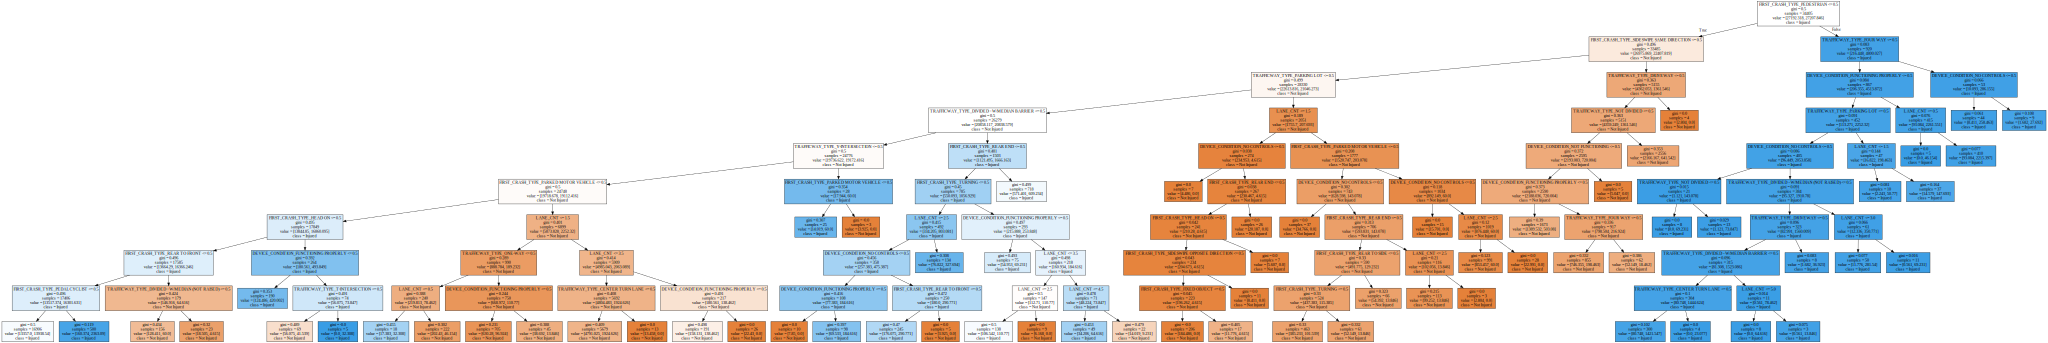

In [53]:
#best_tree
best_recall_tree = best_recall_tree_selector(min_samples_leaf = 3, 
                                             min_samples_split = 6, 
                                             max_depth = 9, 
                                             random_state = 0, 
                                             class_weight = 'balanced')

import graphviz
fn = X_train.columns
cn = ['Not Injured', 'Injured'] # Target classes in ascending numerical order.

dot_data = tree.export_graphviz(best_recall_tree, out_file=None, feature_names=fn, class_names=cn, filled=True)

graph = graphviz.Source(dot_data, format="png")
graph

**Inspect tree outside of Jupyter**

In [57]:
# Export tree as dot file
best_recall_tree = best_recall_tree_selector(min_samples_leaf = 3, 
                                             min_samples_split = 6, 
                                             max_depth = 9, 
                                             random_state = 0, 
                                             class_weight = 'balanced')
import graphviz
fn = X_train.columns
cn = ['Not Injured', 'Injured'] # Target classes in ascending numerical order.

tree.export_graphviz(best_recall_tree, out_file="dot_tree_1.dot", feature_names=fn, class_names=cn, filled=True)

In [58]:
# Convert dot file into png
!dot -Tpng -Gdpi=800 dot_tree_1.dot -o dot_tree_1.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.430924 to fit


In [59]:
#elapsed = timeit.default_timer() - start_time
#print("Total runtime of the script is", round(elapsed, 2), "seconds.")

# Shantanu 

In [417]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [418]:
df=pd.read_csv("Preprocessed_data.csv")

In [419]:
#features=['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION','TRAFFICWAY_TYPE','INTERSECTION_RELATED_I',
#          'LANE_CNT','FIRST_CRASH_TYPE','FATALITIES','INJURY']

#for col in features:
#    print('\033[1m', '\nColumn:', col, '\033[0m')
#    print(df[col].value_counts())

In [420]:
def injury_fatality_summarizer(col, df=df):
    x=df[df['INJURY']=='INJURED'][col].value_counts(normalize=True).reset_index(name='injury').sort_values(["index"])
    y=df[df['FATALITIES']=='FATAL'][col].value_counts(normalize=True).reset_index(name='fatal').sort_values(["index"])
    
    table=x.merge(y, how='inner', on=['index']).sort_values(['fatal','injury'], ascending=False)
    table=table.rename(columns={'index':col, 'injury':'PERCENTAGE OF INJURIES', 'fatal':'PERCENTAGE OF FATALITIES'})
    return(table)

In [421]:
def injury_fatality_plotter(col, df=df):
    plt.figure(figsize=(12, 5))
    df_plot1 = df[df['INJURY']=='INJURED'][col].value_counts(normalize=True)
    sns.barplot(x=df_plot1.values*100, y=df_plot1.index, alpha=0.9)
    plt.title('Percentage of Injuries by The Levels of '+str(col).replace("_", " ").title(), fontsize=18)
    plt.xlabel('Percentage', fontsize=14)
    plt.show()

    plt.figure(figsize=(12, 5))
    df_plot2 = df[df['FATALITIES']=='FATAL'][col].value_counts(normalize=True)
    sns.barplot(x=df_plot2.values*100, y=df_plot2.index, alpha=0.9)
    plt.title('Percentage of Fatalities by The Levels of '+str(col).replace("_", " ").title(), fontsize=18)
    plt.xlabel('Percentage', fontsize=14)
    plt.show()

## Summary Tables

- **54% of fatalities** and **45% of injuries** happened in roads with **no control devices**.
- **50% of fatalities** and **48% of injuries** happened in roads with **control devices whose conditions are not controlled.**
- **92% of fatalities** and **75% of injuries** happened in **undivided roads.**

In [422]:
injury_fatality_summarizer('TRAFFIC_CONTROL_DEVICE')

,TRAFFIC_CONTROL_DEVICE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,NO_SIGN,0.454515,0.546875
1,SIGN,0.545485,0.453125


In [424]:
injury_fatality_summarizer('DEVICE_CONDITION')

,DEVICE_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,FUNCTIONING PROPERLY,0.496775,0.5
1,NO CONTROLS,0.483367,0.5


In [426]:
injury_fatality_summarizer('FIRST_CRASH_TYPE')

,FIRST_CRASH_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
10,TURNING,0.157162,0.234375
3,PARKED MOTOR VEHICLE,0.079769,0.156250
5,PEDESTRIAN,0.188221,0.140625
0,ANGLE,0.178547,0.109375
1,FIXED OBJECT,0.034453,0.093750
4,PEDALCYCLIST,0.085200,0.078125
8,SIDESWIPE OPPOSITE DIRECTION,0.013917,0.062500
6,REAR END,0.169722,0.046875
9,SIDESWIPE SAME DIRECTION,0.057366,0.031250
7,REAR TO FRONT,0.002885,0.031250


In [428]:
injury_fatality_summarizer('TRAFFICWAY_TYPE')

,TRAFFICWAY_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,NOT_DIVIDED,0.748473,0.921875
0,DIVIDED,0.251527,0.078125


In [430]:
injury_fatality_summarizer('INTERSECTION_RELATED_I')

,INTERSECTION_RELATED_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,Y,0.424474,0.53125
0,N,0.575526,0.46875


## Plots 

**Traffic Control Device**


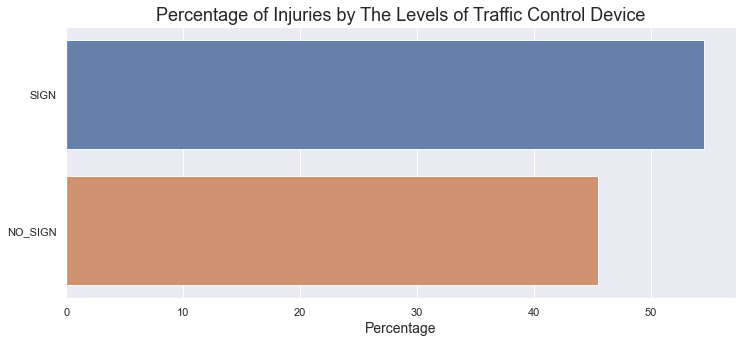

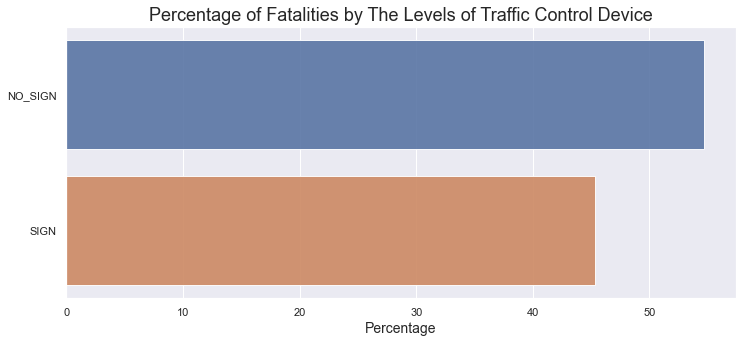

In [423]:
injury_fatality_plotter('TRAFFIC_CONTROL_DEVICE')

**Device Condition**

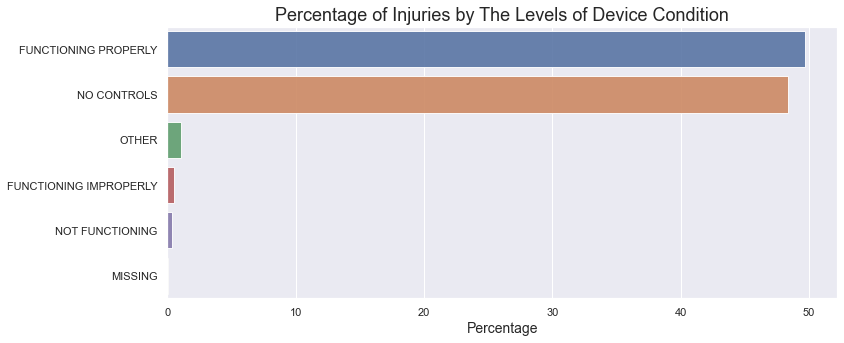

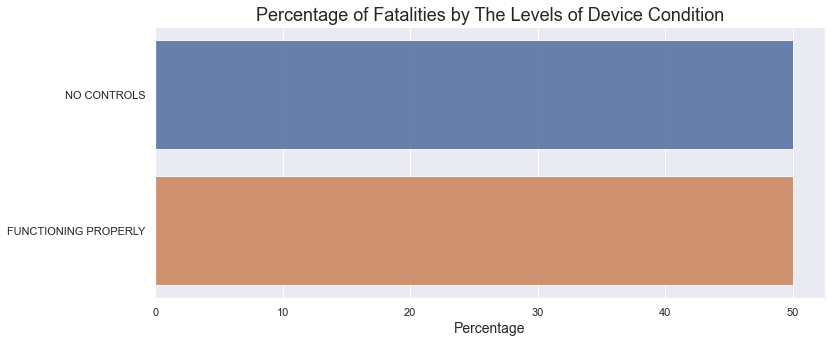

In [425]:
injury_fatality_plotter('DEVICE_CONDITION')

**First Crash Type**

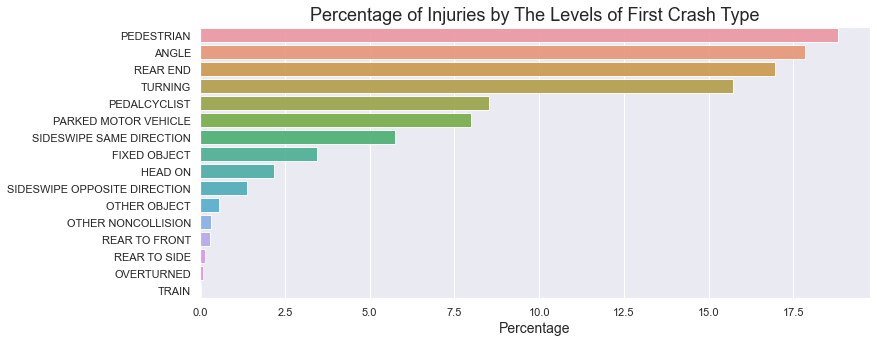

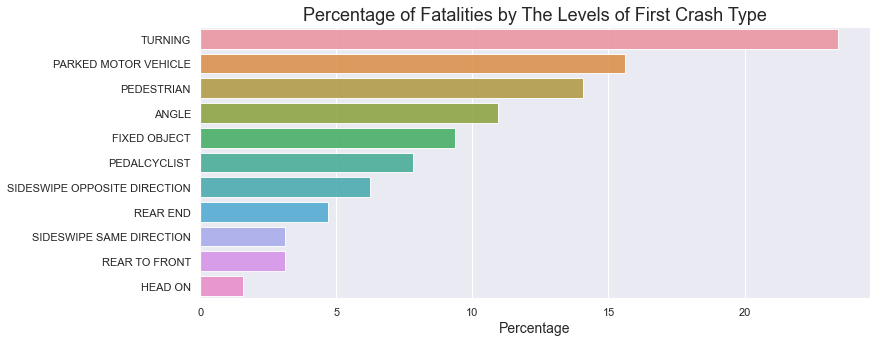

In [427]:
injury_fatality_plotter('FIRST_CRASH_TYPE')

**Type of Traffic Way**

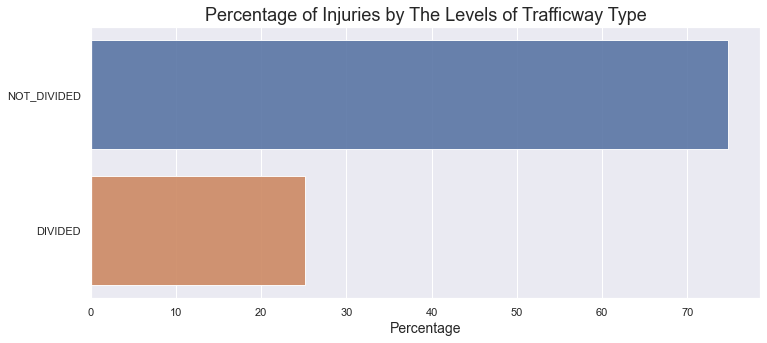

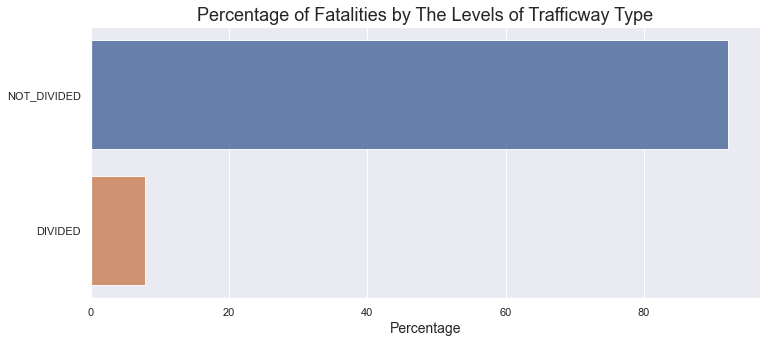

In [429]:
injury_fatality_plotter('TRAFFICWAY_TYPE')

**Intersections**

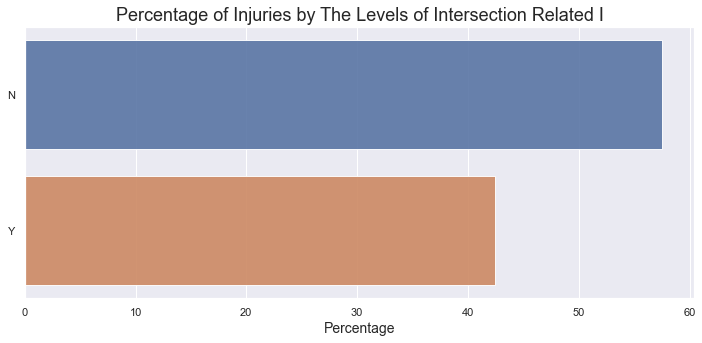

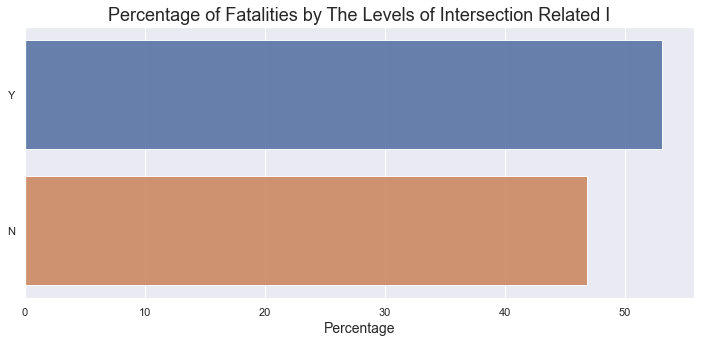

In [431]:
injury_fatality_plotter('INTERSECTION_RELATED_I')